# **Machine translation model : English to Arabic**

### libraries implementation

In [ ]:
import string
import re
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import nltk.tokenize
from array import array
from numpy import array , argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense , LSTM , Embedding , RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
#pd.set_option('display.max_coldwidth',200)

In [ ]:
data_path = 'eng_ara.txt'
with open(data_path, 'r',encoding='utf-8') as f:
    lines=f.read()
lines

'Hi.\tمرحبًا.\nRun!\tاركض!\nHelp!\tالنجدة!\nJump!\tاقفز!\nStop!\tقف!\nGo on.\tداوم.\nGo on.\tاستمر.\nHello!\tمرحباً.\nHurry!\tتعجّل!\nHurry!\tاستعجل!\nI see.\tانا اري\nI won!\tأنا فُزت!\nRelax.\tاسترح.\nSmile.\tابتسم.\nCheers!\tفي صحتك.\nGot it?\tهل فهمت؟\nHe ran.\tركض.\nI know.\tأعرف.\nI know.\tأعلم ذلك.\nI know.\tأنا أعلم\nI\'m 19.\tأنا في 19\nI\'m OK.\tأنا بخير.\nListen.\tاستمع\nNo way!\tغير معقول!\nReally?\tحقاً؟\nThanks.\tشكرا.\nWhy me?\tلماذا أنا؟\nAwesome!\tرائع!\nBe cool.\tخذ راحتك.\nCall me.\tهاتفني.\nCall me.\tاتصل بي.\nCome in.\tتفضل بالدخول.\nCome in.\tتعال إلى الداخل\nCome on!\tبالله عليك!\nCome on!\tهيا\nCome on!\tهيّا\nGet out!\tاخرج من هنا!\nGet out!\tأُخرج!\nGet out.\tاخرج!\nGo away.\tاتركني و شأني.\nGo away.\tاذهب بعيداً.\nGo away.\tارحل.\nGoodbye!\tمع السلامة.\nHe came.\tلقد أتى.\nHe runs.\tهو يجري\nHelp me!\tساعدني!\nHelp me.\tالنجدة! ساعدني!\nI\'m sad.\tأنا حزين.\nMe, too.\tأنا أيضاً.\nShut up!\tاخرس!\nShut up!\tاصمت!\nShut up!\tاسكت!\nShut up!\tأغلق فمك!\nStop it.

# Data preprocessing

In [ ]:
def to_lines (text):
    sents = text.strip().split('\n')
    sents = [i.split('\t')for i in sents]
    return sents

In [ ]:
eng_ara = to_lines(lines)
eng_ara[:5]

[['Hi.', 'مرحبًا.'],
 ['Run!', 'اركض!'],
 ['Help!', 'النجدة!'],
 ['Jump!', 'اقفز!'],
 ['Stop!', 'قف!']]

In [ ]:
eng_ara = array(eng_ara)
eng_ara[:5]

array([['Hi.', 'مرحبًا.'],
       ['Run!', 'اركض!'],
       ['Help!', 'النجدة!'],
       ['Jump!', 'اقفز!'],
       ['Stop!', 'قف!']], dtype='<U1281')

In [ ]:
eng_ara.shape

(24638, 2)

In [ ]:
eng_ara = eng_ara [:15000,:]

# to reduce the data so reduce the training data time

In [ ]:
#print(eng_ara)

# Data `Cleansing`

In [ ]:
#Punctuation removing
eng_ara[:,0] = [s.translate(str.maketrans('','', string.punctuation)) for s in eng_ara[:,0]]
eng_ara[:,1] = [s.translate(str.maketrans('','', string.punctuation)) for s in eng_ara[:,1]]

eng_ara[:5]

array([['Hi', 'مرحبًا'],
       ['Run', 'اركض'],
       ['Help', 'النجدة'],
       ['Jump', 'اقفز'],
       ['Stop', 'قف']], dtype='<U1281')

In [ ]:
#lowercasing
for i in range(len(eng_ara)):
  eng_ara[i,0] = eng_ara[i,0].lower()
  eng_ara[i,1] = eng_ara[i,1].lower()
eng_ara

array([['hi', 'مرحبًا'],
       ['run', 'اركض'],
       ['help', 'النجدة'],
       ...,
       ['i recommend our doctors twitter beginners tolubaiev oxanalivshits drmedvedev ihorkyrpa sokolovmd ff sledui',
        'انصح بمتابعة اطباينا مبتديي تويتر'],
       ['doctors of dnipropetrovsk regional clinical hospital named after ilya ilyich mechnikov photo by dnipropetrovsk regional hospital',
        'اطباء مستشفى دنيبروبتروفسك التي سميت على اسم العالم ايليا ميتشينيكوف الصورة من مستشفى دنيبروبتروفسك'],
       ['while their activity may be pioneering for ukraine there is an international directory en of the most influential doctors on twitter which currently contains names and is updated on an hourly basis',
        'بينما يعد نشاطهم ريادي وهو الاول من نوعه في اوكرانيا يوجد فهرس بالانجليزية دولي لاغلب الاطباء الموثرين على تويتر يحتوي حاليا على اسم ويتم تحديثه على مدار الساعة']],
      dtype='<U1281')

# Word indexing and tokenization

In [ ]:
#function to build a tokenizer

from keras.preprocessing.text import Tokenizer

def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#prepare English tokenizer
eng_tokenizer = tokenization(eng_ara[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print (' English vocabulary size : ' , eng_vocab_size)

 English vocabulary size :  14132


In [ ]:
#prepare Arabic tokenizer
ara_tokenizer = tokenization(eng_ara[:,1])
ara_vocab_size = len(ara_tokenizer.word_index) + 1

ara_length = 8
print (' Arabic vocabulary size : ' , ara_vocab_size)

 Arabic vocabulary size :  31748


In [ ]:
#encode and pad sequences , padding to a maximum sentence length as mentioned above
def encode_sequence(tokenizer, length, lines):
  #integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 value
  seq = pad_sequences(seq, maxlen=length, padding = 'post')
  return seq

# Data splitting


In [ ]:
from sklearn.model_selection import train_test_split

#to split the data into test and train data sets
train,test = train_test_split(eng_ara, test_size=0.2 ,random_state = 12 )

In [ ]:
#prepare training data

train_eng = encode_sequence(eng_tokenizer, eng_length , train[:,0] )
train_ara = encode_sequence(ara_tokenizer , ara_length , train[:,1])

#prepare test data
test_eng = encode_sequence(eng_tokenizer, eng_length , test[:,0] )
test_ara = encode_sequence(ara_tokenizer , ara_length , test[:,1])

# Model architecture

In [ ]:
#build nmt(Neural machine translation) model
def define_model(in_vocab, out_vocab , in_timesteps , out_timesteps , units ):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab,activation= 'softmax'))
  return model

In [ ]:
#we are using rms model optimizer in this model as it's usually a good choice when working with recurrent nural network

#model compilation
model = define_model(eng_vocab_size, ara_vocab_size, eng_length, ara_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms , loss = 'sparse_categorical_crossentropy', metrics=["accuracy"])

# Model training

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="./models/best.keras",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
  #train model

  history = model.fit(train_eng,train_ara.reshape(train_ara.shape[0],train_ara.shape[1],1),
                      epochs = 15
                      , batch_size = 80 , validation_split = 0.2, callbacks=[model_checkpoint_callback])

Epoch 1/15
120/120 [==============================] - 20s 102ms/step - loss: 6.5799 - accuracy: 0.3594 - val_loss: 5.8057 - val_accuracy: 0.3758
Epoch 2/15
120/120 [==============================] - 8s 67ms/step - loss: 5.7433 - accuracy: 0.3690 - val_loss: 5.6630 - val_accuracy: 0.3771
Epoch 3/15
120/120 [==============================] - 8s 64ms/step - loss: 5.6122 - accuracy: 0.3704 - val_loss: 5.6693 - val_accuracy: 0.3774
Epoch 4/15
120/120 [==============================] - 8s 65ms/step - loss: 5.5329 - accuracy: 0.3724 - val_loss: 5.5726 - val_accuracy: 0.3826
Epoch 5/15
120/120 [==============================] - 8s 68ms/step - loss: 5.4662 - accuracy: 0.3739 - val_loss: 5.5289 - val_accuracy: 0.3862
Epoch 6/15
120/120 [==============================] - 8s 63ms/step - loss: 5.3988 - accuracy: 0.3754 - val_loss: 5.5047 - val_accuracy: 0.3871
Epoch 7/15
120/120 [==============================] - 7s 58ms/step - loss: 5.3394 - accuracy: 0.3768 - val_loss: 5.4736 - val_accuracy: 0.38

In [ ]:
model = tf.keras.models.load_model('./models/best.keras')

# Graph

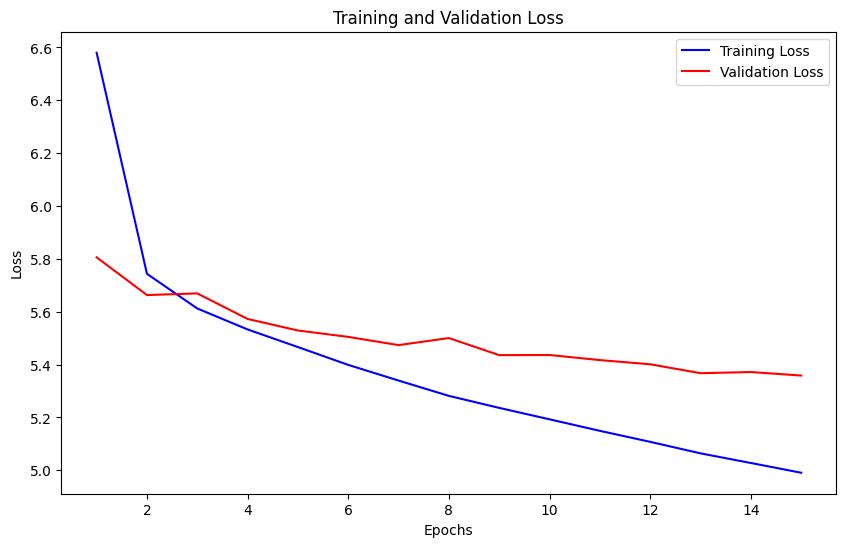

In [ ]:
# Assuming 'history' contains the training history from model.fit()

# Accessing loss and validation loss values
training_loss = history.history ['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

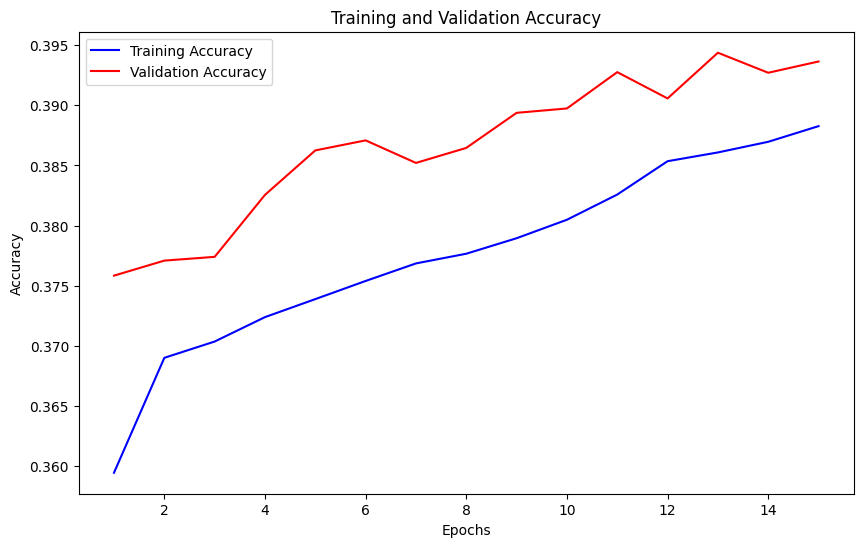

In [ ]:
# Accessing accuracy and validation accuracy values
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

# Plotting accuracy and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction

In [ ]:
#test_eng.shape

In [ ]:
#model.evaluate(test_eng, test_ara)

In [ ]:
#tmp = test_eng.reshape((test_eng.shape[0], test_eng.shape[1]))

In [ ]:
# Use predict method to get predicted probabilities
pred_probs = model.predict(test_eng.reshape((test_eng.shape[0], test_eng.shape[1])))

# Use argmax to get the class indices
preds = pred_probs.argmax(axis=-1)

# Now, preds contains the predicted class indices for each sequence in the test data


94/94 [==============================] - 1s 9ms/step


In [ ]:
preds

array([[ 4,  5,  5, ...,  0,  0,  0],
       [ 2,  1,  1, ...,  1,  1,  0],
       [ 4,  1,  0, ...,  0,  0,  0],
       ...,
       [ 2,  2,  2, ...,  0,  0,  0],
       [ 2,  1,  0, ...,  0,  0,  0],
       [16,  1,  0, ...,  0,  0,  0]])

In [ ]:
def get_word(token_id, tokenizer):
  for word , index in tokenizer.word_index.items():
    if index == token_id :
      return word
  return None

In [ ]:
preds_text = []
for i in preds :
  temp = []
  for j in range(len(i)):
    t = get_word(i[j] , ara_tokenizer)
    if j > 0 :
      if (t == get_word(i[j-1], ara_tokenizer )) or (t == None ):
        temp.append(' ')
      else :
        temp.append(t)
    else :
      if (t == None):
        temp.append(' ')
      else :
        temp.append(t)

  preds_text.append(' '.join(temp))

# let's put the Original scentence in the dataset and the predicted sentences in a dataframe

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,1] , 'predicted' : preds_text})

In [ ]:
    #print 15  rows randomly
pred_df.sample(15)

# translation using hugging face

In [ ]:
# !pip install transformers[sentencepiece]

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("translation_en_to_ar", model="marefa-nlp/marefa-mt-en-ar")

# Translate text
text = "how are you?"
output = pipe(text)

print(output)